## Data Preparation

### Getting data from yfinance

In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

import numpy as np
import os
import json

import pandas as pd
from sklearn.preprocessing import StandardScaler

from ta.momentum import RSIIndicator
from ta.trend import EMAIndicator, MACD
from ta.volatility import AverageTrueRange

import yfinance as yf
from torch.utils.tensorboard import SummaryWriter

config = {
    "yfinance": {
        "symbol": "AAPL",
        "symbols": [
            "AAPL", "MSFT", "GOOG", "AMZN",
            "META", "NVDA", "SPY", "XLK", 
            "TSLA", "CRM", "ADBE", "QCOM"
        ],
        "period": "10y",
        "interval": "1d",
    },
    "data": {
        "window_size": 90, 
        "train_split_size": 0.70,
        "val_split_size": 0.15,
        "test_split_size": 0.15,
    }, 
    "plots": {
        "xticks_interval": 90,
        "color_actual": "#ff8000",
        "color_train": "#58F6AF",
        "color_val": "#7CC2FF",
        "color_test": "#FF6464",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#00529A",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "num_lstm_layers": 2,
        "lstm_size": 64, # hidden state dimensionality
        "dropout": 0.3,
    },
    "training": {
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "batch_size": 128,
        "num_epoch": 100,
        "learning_rate": 5e-4,
        "weight_decay": 1e-2,
        "scheduler_step_size": 40,
    }
}

In [2]:
data_list = []

for symbol in config["yfinance"]["symbols"]:
    ticker = yf.Ticker(symbol)
    df = ticker.history(start="2015-01-01", interval=config["yfinance"]["interval"], auto_adjust=True, actions=False)
    df = df.add_prefix(f"{symbol}_")
    data_list.append(df)

combined_df = pd.concat(data_list, axis=1)
combined_df

,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Volume,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,MSFT_Volume,...,ADBE_Open,ADBE_High,ADBE_Low,ADBE_Close,ADBE_Volume,QCOM_Open,QCOM_High,QCOM_Low,QCOM_Close,QCOM_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00-05:00,24.718174,24.729270,23.821672,24.261047,212818400,39.847665,40.496704,39.745186,39.933064,27913900,...,72.699997,73.199997,71.889999,72.339996,2349200,55.093433,55.359621,54.531480,54.923367,6662700
2015-01-05 00:00:00-05:00,24.030265,24.110152,23.391175,23.577576,257142000,39.600003,39.907444,39.497524,39.565845,39673900,...,72.209999,72.430000,71.570000,71.980003,2403300,54.501914,55.086049,54.442760,54.664585,12042800
2015-01-06 00:00:00-05:00,23.641928,23.839424,23.218085,23.579794,263188400,39.608527,39.924506,38.891167,38.985107,36447900,...,71.949997,72.099998,69.879997,70.529999,2895400,54.612835,55.167392,53.784693,53.888210,11094000
2015-01-07 00:00:00-05:00,23.788385,24.010292,23.677432,23.910435,160423600,39.266927,39.676846,38.848468,39.480427,29114100,...,70.769997,71.290001,70.419998,71.110001,2378300,54.250543,55.063893,53.947382,54.516731,10030700
2015-01-08 00:00:00-05:00,24.238856,24.886823,24.121244,24.829126,237458000,39.924516,40.778516,39.898897,40.641876,29645200,...,71.400002,73.059998,71.309998,72.919998,2624200,54.938150,55.677560,54.819842,55.093426,10937200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-18 00:00:00-04:00,231.699997,233.119995,230.110001,230.889999,37476200,520.733964,521.961925,513.176381,516.251282,23760600,...,355.679993,358.390015,353.000000,357.239990,2923000,157.779999,159.750000,157.240005,158.899994,4774400
2025-08-19 00:00:00-04:00,231.279999,232.869995,229.350006,230.559998,39402600,514.154777,514.314488,507.715351,508.933350,21481000,...,359.220001,364.239990,358.119995,361.029999,2808000,159.070007,159.429993,156.050003,156.250000,6396500
2025-08-20 00:00:00-04:00,229.979996,230.470001,225.770004,226.009995,42263900,509.033198,510.161348,503.612117,504.890015,27723000,...,361.679993,363.000000,353.200012,353.429993,3727900,156.389999,156.639999,153.460007,155.440002,7151700


In [ ]:
combined_df["Date"] = pd.to_datetime(raw_data["Date"]).dt.strftime("%Y-%m-%d")
raw_data.to_json(json_file, orient="records", indent=4, date_format="iso")

In [453]:
with open(json_file, "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)
df

,Date,Open,High,Low,Close,Volume
0,2000-08-23,60.078906,61.795448,59.860438,61.545769,4446755
1,2000-08-24,61.420887,62.638070,61.264841,62.325974,6263762
2,2000-08-25,62.076290,64.853962,62.045079,64.417023,8659834
3,2000-08-28,64.853974,66.508093,64.791553,65.665428,8929284
4,2000-08-29,65.665436,67.038669,65.415757,66.352051,6317840
...,...,...,...,...,...,...
6282,2025-08-18,239.570007,241.419998,239.119995,239.449997,3569600
6283,2025-08-19,240.000000,242.830002,239.490005,241.279999,3328300
6284,2025-08-20,242.110001,242.880005,240.339996,242.550003,3240100
6285,2025-08-21,242.210007,242.500000,238.649994,239.399994,2991900


### Compute technical indicators

In [3]:
all_indicators = []

for symbol in config["yfinance"]["symbols"]:
    df_ind = pd.DataFrame(index=combined_df.index)
    close = combined_df[f"{symbol}_Close"]
    high = combined_df[f"{symbol}_High"]
    low = combined_df[f"{symbol}_Low"]
    volume = combined_df[f"{symbol}_Volume"]

    # Price-based indicators
    df_ind[f"{symbol}_Return"] = close.pct_change() # daily returns

    # Momentum indicators
    macd = MACD(close)
    df_ind[f"{symbol}_MACD_diff"] = macd.macd_diff()
    df_ind[f"{symbol}_RSI_14"] = RSIIndicator(close, window=14).rsi()

    # Volatility
    df_ind[f"{symbol}_ATR_14"] = AverageTrueRange(high, low, close, window=14).average_true_range()

    # Volume
    df_ind[f"{symbol}_Volume"] = volume

    all_indicators.append(df_ind)

# Concatenate all indicator columns at once
indicators_df = pd.concat(all_indicators, axis=1)
combined_df = pd.concat([combined_df, indicators_df], axis=1)

combined_df = combined_df.iloc[35:].reset_index(drop=True)
combined_df

,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Volume,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,MSFT_Volume,...,ADBE_Return,ADBE_MACD_diff,ADBE_RSI_14,ADBE_ATR_14,ADBE_Volume,QCOM_Return,QCOM_MACD_diff,QCOM_RSI_14,QCOM_ATR_14,QCOM_Volume
0,29.616694,29.763731,29.222368,29.445150,276912400,37.972447,38.101457,37.774626,37.920841,25271700,...,-0.005378,0.496518,67.904909,1.340718,1954300,0.006061,0.392746,54.737408,1.143996,10131900
1,29.309239,29.318152,28.549551,28.692131,298846800,37.800424,37.920834,37.671411,37.834827,29759800,...,0.005021,0.420846,69.233108,1.314239,1256400,0.004344,0.374731,56.044040,1.126716,10578100
2,28.692141,29.155528,28.206477,29.055277,365150000,37.834837,38.041254,37.748827,37.895042,28957300,...,0.011400,0.396672,72.073340,1.295365,1546000,0.004603,0.361933,57.451913,1.081094,9838700
3,28.961709,29.088697,28.569613,28.618626,248059200,37.955241,38.015446,37.551003,37.714417,33807700,...,0.001773,0.357276,72.503342,1.300696,3115800,0.006944,0.360273,59.565413,1.076230,10297400
4,28.794616,29.024082,28.582974,28.758970,192386800,37.559612,38.006853,37.456403,37.740231,31924000,...,0.008723,0.344690,74.580760,1.284218,1497700,0.007907,0.368320,61.902189,1.067885,8979300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2636,231.699997,233.119995,230.110001,230.889999,37476200,520.733964,521.961925,513.176381,516.251282,23760600,...,0.006735,2.057283,49.969949,8.215905,2923000,0.006652,1.046060,59.734562,3.627591,4774400
2637,231.279999,232.869995,229.350006,230.559998,39402600,514.154777,514.314488,507.715351,508.933350,21481000,...,0.010609,2.739560,52.765231,8.129054,2808000,-0.016677,0.955383,53.924198,3.609905,6396500
2638,229.979996,230.470001,225.770004,226.009995,42263900,509.033198,510.161348,503.612117,504.890015,27723000,...,-0.021051,2.611958,47.084187,8.248407,3727900,-0.005184,0.802782,52.251192,3.579197,7151700
2639,226.270004,226.520004,223.779999,224.899994,30621200,503.690002,507.630005,502.720001,504.239990,18443300,...,0.000000,2.462491,47.084187,8.146378,2363200,-0.008428,0.585630,49.572481,3.494254,4997300


In [287]:
data_dates = df["Date"].tolist()
num_data_points = len(df)
display_date_range = f"from {data_dates[0]} to {data_dates[-1]}"

print("Number of data points:", num_data_points, display_date_range)
df.head()

KeyError: 'Date'

### Visualize

In [4]:
features = ["Return", "MACD_diff", "ATR_14", "RSI_14", "Volume"]
features_cols = []

for feature in features:
    for symbol in config["yfinance"]["symbols"]:
        features_cols.append(f"{symbol}_{feature}")

combined_df_features = combined_df[features_cols]
combined_df_features

,AAPL_Return,MSFT_Return,GOOG_Return,AMZN_Return,META_Return,NVDA_Return,SPY_Return,XLK_Return,TSLA_Return,CRM_Return,...,XLK_Volume,XLK_Volume,TSLA_Volume,TSLA_Volume,CRM_Volume,CRM_Volume,ADBE_Volume,ADBE_Volume,QCOM_Volume,QCOM_Volume
0,-0.006241,-0.001359,0.007859,-0.004077,-0.004947,0.010646,0.002841,0.003016,-0.015578,-0.010387,...,4655500,4655500,99054000,99054000,5481700,5481700,1954300,1954300,10131900,10131900
1,-0.025574,-0.002268,0.014513,0.017908,0.014149,-0.007620,-0.000850,-0.006245,-0.001715,0.015178,...,5867400,5867400,58642500,58642500,7634000,7634000,1256400,1256400,10578100,10578100
2,0.012657,0.001592,0.021347,-0.001479,0.010684,0.002710,-0.001181,0.006284,0.016834,0.117226,...,7559400,7559400,97093500,97093500,20370800,20370800,1546000,1546000,9838700,9838700
3,-0.015028,-0.004766,0.005257,-0.012058,-0.017908,-0.006306,-0.003407,-0.003470,-0.018582,-0.012244,...,6056000,6056000,58231500,58231500,8289500,8289500,3115800,3115800,10297400,10297400
4,0.004904,0.000684,0.023173,0.014468,0.009877,0.024479,0.006314,0.007891,-0.029556,-0.013260,...,6844500,6844500,118831500,118831500,8124800,8124800,1497700,1497700,8979300,8979300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2636,-0.003023,-0.005902,-0.003026,0.001991,-0.022745,0.008645,-0.000218,0.002145,0.013916,0.006311,...,6116900,6116900,56956600,56956600,8809200,8809200,2923000,2923000,4774400,4774400
2637,-0.001429,-0.014175,-0.008811,-0.015033,-0.020707,-0.034998,-0.005425,-0.017463,-0.017454,0.008321,...,8683500,8683500,75956000,75956000,8642200,8642200,2808000,2808000,6396500,6396500
2638,-0.019735,-0.007945,-0.011359,-0.018420,-0.005003,-0.001366,-0.002657,-0.006765,-0.016428,0.001829,...,11532100,11532100,77481800,77481800,8195100,8195100,3727900,3727900,7151700,7151700
2639,-0.004911,-0.001287,0.002148,-0.008311,-0.011528,-0.002395,-0.004012,-0.003617,-0.011701,-0.002516,...,7574300,7574300,55744400,55744400,5646800,5646800,2363200,2363200,4997300,4997300


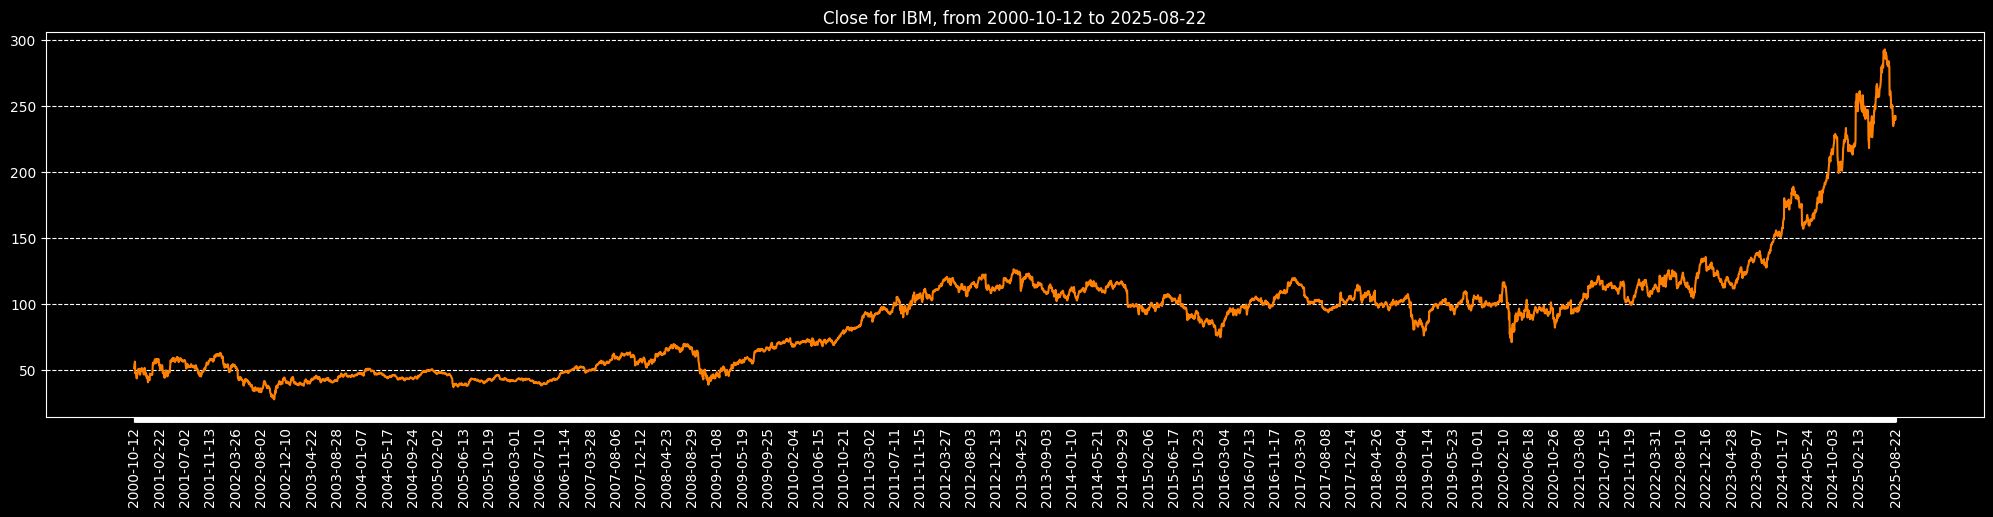

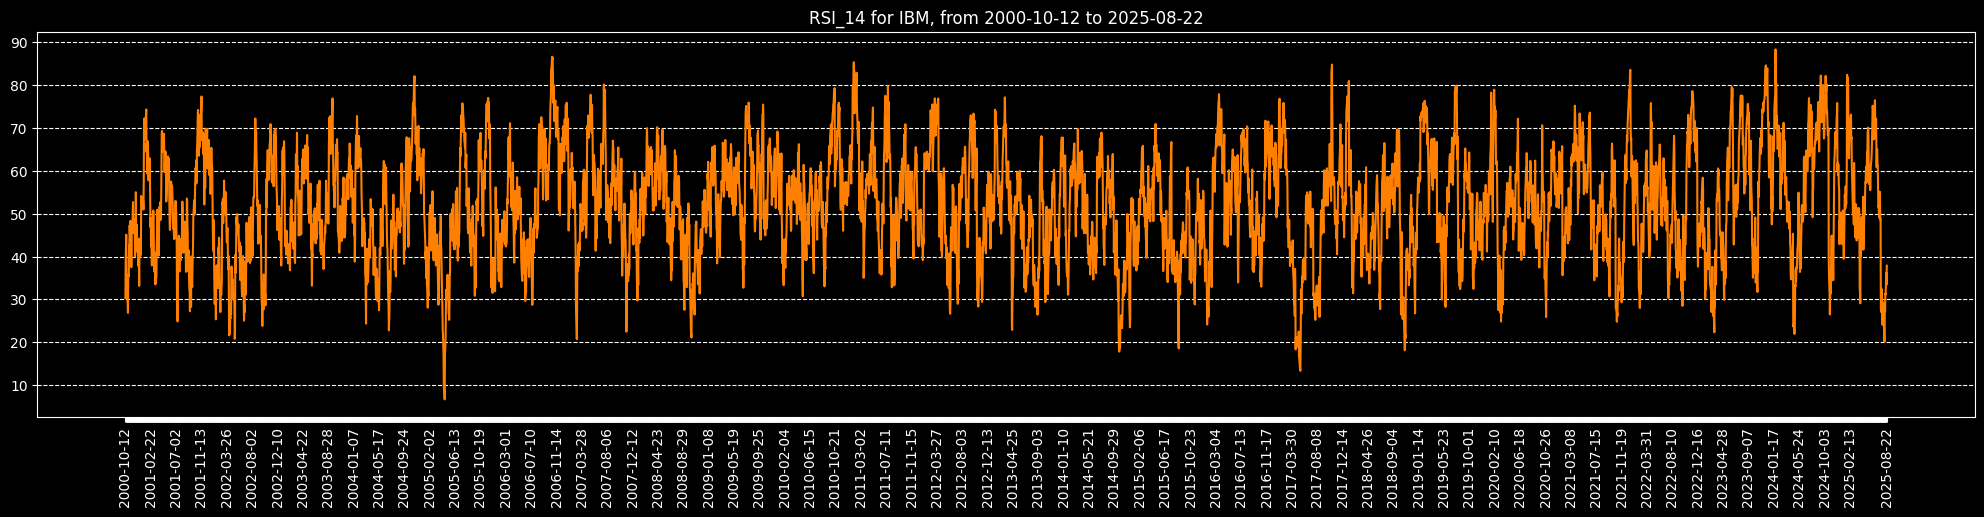

In [457]:
plt.style.use("dark_background")

def plot_feature(data_dates, df, feature, num_data_points, display_date_range):
    fig = plt.figure(figsize=(25, 5), dpi=100)
    fig.patch.set_facecolor(color="black")

    plt.plot(data_dates, df[feature].to_list(), color=config["plots"]["color_actual"])

    xticks_labels = []
    xticks_interval = config["plots"]["xticks_interval"]

    for i in range(num_data_points):
        # Always include the last data point
        if i == num_data_points - 1:
            xticks_labels.append(data_dates[i])
        # Include every xticks_interval-th point, but avoid ticks too close to the end
        elif i % xticks_interval == 0 and (num_data_points - i) > xticks_interval:
            xticks_labels.append(data_dates[i])
        else:
            xticks_labels.append(None)

    xticks_indices = np.arange(0, len(xticks_labels))
    plt.xticks(xticks_indices, xticks_labels, rotation="vertical")

    plt.title(f"{feature} for {config["yfinance"]["symbol"]}, {display_date_range}")
    plt.grid(axis="y", linestyle="--")

plot_feature(data_dates, df_features, "Close", num_data_points, display_date_range)
plot_feature(data_dates, df_features, "RSI_14", num_data_points, display_date_range)

### Normalizing raw data

In [5]:
combined_df_features = combined_df_features.copy()

for col in features_cols:
    if col.endswith("RSI_14"):
        combined_df_features[col] = (combined_df_features[col] / 100.0)
    else:
        combined_df_features[col] = (combined_df_features[col] - combined_df_features[col].mean()) / combined_df_features[col].std()

combined_df_features

,AAPL_Return,MSFT_Return,GOOG_Return,AMZN_Return,META_Return,NVDA_Return,SPY_Return,XLK_Return,TSLA_Return,CRM_Return,...,XLK_Volume,XLK_Volume,TSLA_Volume,TSLA_Volume,CRM_Volume,CRM_Volume,ADBE_Volume,ADBE_Volume,QCOM_Volume,QCOM_Volume
0,-0.392159,-0.145965,0.380985,-0.253012,-0.255036,0.256703,0.201423,0.143870,-0.475435,-0.508330,...,-0.843230,-0.843230,-0.183045,-0.183045,-0.148584,-0.148584,-0.606428,-0.606428,-0.045599,-0.045599
1,-1.448015,-0.199368,0.747631,0.809984,0.544332,-0.331966,-0.123919,-0.470247,-0.097996,0.656967,...,-0.646981,-0.646981,-0.739413,-0.739413,0.365805,0.365805,-1.008617,-1.008617,0.018094,0.018094
2,0.639898,0.027305,1.124222,-0.127385,0.399272,0.000965,-0.153082,0.360598,0.406989,5.308425,...,-0.372986,-0.372986,-0.210036,-0.210036,3.409833,3.409833,-0.841725,-0.841725,-0.087452,-0.087452
3,-0.872090,-0.346081,0.237625,-0.638876,-0.797605,-0.289610,-0.349243,-0.286211,-0.557212,-0.592983,...,-0.616440,-0.616440,-0.745071,-0.745071,0.522466,0.522466,0.062926,0.062926,-0.021975,-0.021975
4,0.216492,-0.025964,1.224859,0.643624,0.365503,0.702515,0.507513,0.467168,-0.855995,-0.639304,...,-0.488754,-0.488754,0.089243,0.089243,0.483103,0.483103,-0.869560,-0.869560,-0.210126,-0.210126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2636,-0.216408,-0.412767,-0.218756,0.040395,-1.000076,0.192232,-0.068164,0.086134,0.327552,0.252768,...,-0.606578,-0.606578,-0.762623,-0.762623,0.646671,0.646671,-0.048182,-0.048182,-0.810354,-0.810354
2637,-0.129391,-0.898623,-0.537528,-0.782708,-0.914772,-1.214290,-0.527168,-1.214224,-0.526511,0.344380,...,-0.190955,-0.190955,-0.501048,-0.501048,0.606759,0.606759,-0.114454,-0.114454,-0.578807,-0.578807
2638,-1.129120,-0.532730,-0.677908,-0.946472,-0.257408,-0.130417,-0.283183,-0.504783,-0.498576,0.048493,...,0.270334,0.270334,-0.480041,-0.480041,0.499905,0.499905,0.415670,0.415670,-0.471007,-0.471007
2639,-0.319559,-0.141769,0.066323,-0.457683,-0.530544,-0.163549,-0.402597,-0.296021,-0.369879,-0.149556,...,-0.370573,-0.370573,-0.779312,-0.779312,-0.109126,-0.109126,-0.370786,-0.370786,-0.778536,-0.778536


In [280]:
feature = "RSI_14"
feature_index = features.index(feature)

fig = plt.figure(figsize=(25, 5), dpi=100)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates, data_scaled_features[:, feature_index], color=config["plots"]["color_actual"])

xticks_labels = []
xticks_interval = config["plots"]["xticks_interval"]

for i in range(num_data_points):
    # Always include the last data point
    if i == num_data_points - 1:
        xticks_labels.append(data_dates[i])
    # Include every xticks_interval-th point, but avoid ticks too close to the end
    elif i % xticks_interval == 0 and (num_data_points - i) > xticks_interval:
        xticks_labels.append(data_dates[i])
    else:
        xticks_labels.append(None)

xticks_indices = np.arange(0, len(xticks_labels))
plt.xticks(xticks_indices, xticks_labels, rotation="vertical")

plt.title(f"{feature} for {config["yfinance"]["symbol"]}, {display_date_range}")
plt.grid(axis="y", linestyle="--")

NameError: name 'data_dates' is not defined

<Figure size 2500x500 with 0 Axes>

### Train/Val split

In [55]:
window_size = config["data"]["window_size"]

target_col = "AAPL_Close"
n_row = combined_df_features.shape[0] - window_size

X = np.array([
    combined_df_features.iloc[i:i+window_size].values 
    for i in range(n_row)
])

raw_prices = combined_df[target_col].values
log_returns = np.log(raw_prices[1:] / raw_prices[:-1])  

y = np.array([
    log_returns[i + window_size - 1] # return[t] = log(p[t+1]/p[t])
    for i in range(n_row)
])


X.shape, y.shape

((2551, 90, 72), (2551,))

In [56]:
train_end = int(config["data"]["train_split_size"] * len(y))
val_end   = int((config["data"]["train_split_size"] + config["data"]["val_split_size"]) * len(y))

# X_train, y_train = X[:train_end], y[:train_end]
# X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
X_trainval, y_trainval = X[:val_end], y[:val_end]
X_test,  y_test  = X[val_end:], y[val_end:]

# print(X_train.shape, y_train.shape)
# print(X_val.shape, y_val.shape)
print(X_trainval.shape, y_trainval.shape)
print(X_test.shape, y_test.shape)

(2168, 90, 72) (2168,)
(383, 90, 72) (383,)


### Datasets and DataLoaders

In [57]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
X_val, y_val = X[train_end:val_end], y[train_end:val_end]

# dataset_train = TimeSeriesDataset(X_train, y_train)
dataset_val = TimeSeriesDataset(X_val, y_val)
dataset_test = TimeSeriesDataset(X_test, y_test)

# print("Train data shape:", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape:", dataset_val.x.shape, dataset_val.y.shape)
print("Test data shape:", dataset_test.x.shape, dataset_test.y.shape)


Validation data shape: torch.Size([383, 90, 72]) torch.Size([383])
Test data shape: torch.Size([383, 90, 72]) torch.Size([383])


In [58]:


# train_dataloader_full = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader_full = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)
test_dataloader = DataLoader(dataset_test, batch_size=config["training"]["batch_size"], shuffle=False)

## LSTM Model

$$
f_t = \sigma(W_{if} x_t + W_{hf} h_{t-1} + b_f) \\
i_t = \sigma(W_{ii} x_t + W_{hi} h_{t-1} + b_i) \\
\tilde{C}_t = \tanh(W_{iC} x_t + W_{hC} h_{t-1} + b_C) \\
o_t = \sigma(W_{io} x_t + W_{ho} h_{t-1} + b_o)
$$

In PyTorch, all the $W_{i*}$ (input -> gate) matrices are stacked together into weight_ih

All the $W_{h*}$ (hidden -> gate) are stacked together into weight_hh

$$
\begin{bmatrix}
f_t \\
i_t \\
\tilde{C}_t \\
o_t
\end{bmatrix}
=
\begin{bmatrix}
\sigma \\
\sigma \\
\tanh \\
\sigma
\end{bmatrix}
\Big(
W_{ih} x_t + W_{hh} h_{t-1} + b_{ih} + b_{hh}
\Big)
$$


In [77]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, attn_heads = 2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.linear_1 = nn.Linear(in_features=input_size, out_features=hidden_layer_size)
        self.relu = nn.ReLU()
        # batch_first = True makes input/output (batch_size, seq_len, feature_num) instead of (seq_len, batch_size, feature_num) 
        self.lstm = nn.LSTM(input_size=hidden_layer_size,
                            hidden_size=hidden_layer_size,
                            num_layers=num_layers, 
                            batch_first=True,
                            dropout=0.1)
        
        self.attention = nn.MultiheadAttention(embed_dim=hidden_layer_size, 
                                               num_heads=attn_heads, 
                                               dropout=0.1,
                                               batch_first=True)

        self.dropout = nn.Dropout(0.1)
        self.linear_2 = nn.Linear(hidden_layer_size, output_size)

        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if "bias" in name:
                 nn.init.zeros_(param)
            elif "weight_ih" in name:
                 nn.init.kaiming_normal_(param) # normal distribution scaled to preserve variance across layers
            elif "weight_hh" in name:
                 nn.init.orthogonal_(param) # preserves the gradient norm so it doesn't vanish/explode


    def forward(self, x):

        x = self.linear_1(x) # (batch, seq_len, num_features) -> (batch, seq_len, hidden_layer_size) 
        x = self.relu(x)

        # output has shape (batch, seq_len, hidden_layer_size). Hidden state from last LSTM layer, at every time step
        # h_n has shape (num_layers, batch, hidden_layer_size). Final hidden state for each layer, at the last time step
        # c_n has the same shape as h_n. Final cell state for each layer, at the last time step.
        lstm_out, (h_n, c_n) = self.lstm(x)

        # x = h_n.transpose(0, 1).reshape(x.shape[0], -1) # (num_layers, batch, hidden_layer_size) -> (batch, num_layers*hidden_layer_size)

        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        
        x = attn_out.mean(dim=1)  # (batch, hidden_layer_size)

        x = self.dropout(x)

        x = self.linear_2(x) # (batch, output_size)
        return x

## Model Training

In [80]:
# import random

writer = SummaryWriter(log_dir="runs/stock_lstm_rolling_trainval_windows")
# seed = random.randint(0, 2**32-1)
# print(f"Using seed: {seed}")
torch.manual_seed(1166543265)


model = LSTMModel(input_size=X.shape[-1], 
                  hidden_layer_size=config["model"]["lstm_size"], 
                  num_layers=config["model"]["num_lstm_layers"], 
                  dropout=config["model"]["dropout"])

model = model.to(config["training"]["device"])

criterion = nn.HuberLoss(delta=1.0)

optimizer = optim.AdamW(params = model.parameters(),
                        lr=config["training"]["learning_rate"],
                        betas=(0.9, 0.98),
                        eps=1e-9,
                        weight_decay=config["training"]["weight_decay"])

# scheduler = optim.lr_scheduler.StepLR(optimizer,
#                                       step_size=config["training"]["scheduler_step_size"],
#                                       gamma=0.1)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode="min", 
    factor=0.5, 
    patience=2,
    min_lr=1e-6
)

device = config["training"]["device"]

best_acc = 0.0
best_val_loss = float("inf")
patience_count = 0


train_window = 1000
val_window = 150
step_size = 200
batch_size = config["training"]["batch_size"]

start = 0
epoch_count = 0

while start + train_window + val_window <= len(X_trainval):
    X_train, y_train = X_trainval[start:start+train_window], y_trainval[start:start+train_window]
    X_val, y_val = X_trainval[start + train_window : start + train_window + val_window], \
                   y_trainval[start + train_window : start + train_window + val_window]

    train_dataloader = DataLoader(
        list(zip(torch.tensor(X_train, dtype=torch.float32),
                 torch.tensor(y_train, dtype=torch.float32))),
        batch_size=batch_size, shuffle=True
    )
    val_dataloader = DataLoader(
        list(zip(torch.tensor(X_val, dtype=torch.float32),
                 torch.tensor(y_val, dtype=torch.float32))),
        batch_size=batch_size, shuffle=False
    )

    
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(
    #     optimizer,
    #     T_max=3,
    #     eta_min=config["training"]["learning_rate"] * 0.02
    # )


    for _ in range(3):
        model.train()
        
        train_loss = 0.0

        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)

            train_pred = model(X)
            train_pred = train_pred.squeeze(-1)

            loss = criterion(train_pred, y)

            optimizer.zero_grad()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.5)
            optimizer.step()

            train_loss += loss.detach().item()

        train_loss = train_loss / len(train_dataloader)

        epoch_count += 1
        writer.add_scalar("Loss/Train", train_loss, epoch_count)

        current_lr = optimizer.param_groups[0]["lr"]

        print(f"Epoch {epoch_count:03d}/{config["training"]["num_epoch"]} | train loss: {train_loss:.6f} | lr: {current_lr:.6f}")

    model.eval()

    val_loss = 0.0
    total_weighted_correct = 0.0
    total_weights = 0.0

    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)

            val_pred = model(X)
            val_pred = val_pred.squeeze(-1)

            val_loss += criterion(val_pred, y).item()

            true_dir = torch.sign(y)
            pred_dir = torch.sign(val_pred)

            # weights = torch.abs(y)
            weights = torch.clamp(torch.abs(y), min=1e-5)

            total_weighted_correct += (true_dir == pred_dir).float().dot(weights).item()
            total_weights += weights.sum().item()


    val_loss = val_loss / len(val_dataloader)

    scheduler.step(val_loss)

    weighted_accuracy = total_weighted_correct / total_weights

    writer.add_scalar("Loss/Validation", val_loss, epoch_count)
    writer.add_scalar("Metrics/WeightedAcc", weighted_accuracy, epoch_count)

    

    # if (weighted_accuracy > best_acc) and (val_loss < best_val_loss * 1.05):  
    #     best_acc = weighted_accuracy
    #     best_val_loss = min(val_loss, best_val_loss)
    #     patience_count = 0
    #     torch.save(model.state_dict(), "best_model.pt")
    # else:
    #     if (patience_count >= 40):
    #         print(f"Early stopping triggered at epoch {epoch}! Best val loss: {best_val_loss}. Best weighted accuracy: {best_acc}")
    #         break
    #     patience_count+=1


    writer.flush()

    if (weighted_accuracy > best_acc) and (val_loss < best_val_loss * 1.05):  
        best_acc = weighted_accuracy
        best_val_loss = min(val_loss, best_val_loss)
        patience_count = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        if (patience_count >= 10):
            print(f"Early stopping triggered at epoch {epoch_count}! Best val loss: {best_val_loss}. Best weighted accuracy: {best_acc}")
            break
        patience_count+=1


    print(f"Train[{start}:{start+train_window}] -> Val[{start+train_window}:{start+train_window+val_window}] "
        f"| Val Loss: {val_loss:.6f} | Acc: {100*weighted_accuracy:.4f}")
    
    start += step_size


Epoch 001/100 | train loss: 0.000313 | lr: 0.000500
Epoch 002/100 | train loss: 0.000182 | lr: 0.000500
Epoch 003/100 | train loss: 0.000150 | lr: 0.000500
Train[0:1000] -> Val[1000:1150] | Val Loss: 0.000115 | Acc: 36.4277
Epoch 004/100 | train loss: 0.000180 | lr: 0.000500
Epoch 005/100 | train loss: 0.000171 | lr: 0.000500
Epoch 006/100 | train loss: 0.000169 | lr: 0.000500
Train[200:1200] -> Val[1200:1350] | Val Loss: 0.000340 | Acc: 46.4703
Epoch 007/100 | train loss: 0.000206 | lr: 0.000500
Epoch 008/100 | train loss: 0.000203 | lr: 0.000500
Epoch 009/100 | train loss: 0.000206 | lr: 0.000500
Train[400:1400] -> Val[1400:1550] | Val Loss: 0.000098 | Acc: 51.7932
Epoch 010/100 | train loss: 0.000221 | lr: 0.000500
Epoch 011/100 | train loss: 0.000217 | lr: 0.000500
Epoch 012/100 | train loss: 0.000215 | lr: 0.000500
Train[600:1600] -> Val[1600:1750] | Val Loss: 0.000318 | Acc: 47.3299
Epoch 013/100 | train loss: 0.000240 | lr: 0.000500
Epoch 014/100 | train loss: 0.000243 | lr: 0.0

In [86]:
model.load_state_dict(torch.load("best_model_acc.pt"))

# torch.save(model.state_dict(), "best_model_acc.pt")

test_loss = 0.0

test_total_weighted_correct = 0.0
test_total_weights = 0.0


val_loss = 0.0
val_total_weighted_correct = 0.0
val_total_weights = 0.0


model.eval()

with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)

        test_pred = model(X)
        test_pred = test_pred.squeeze(-1)

        test_loss += criterion(test_pred, y).item()

        true_dir = torch.sign(y)
        pred_dir = torch.sign(test_pred)

        weights = torch.abs(y)

        test_total_weighted_correct += (true_dir == pred_dir).float().dot(weights).item()
        test_total_weights += weights.sum().item()

    for X, y in val_dataloader_full:
        X, y = X.to(device), y.to(device)

        val_pred = model(X)
        val_pred = val_pred.squeeze(-1)

        val_loss += criterion(val_pred, y).item()
        
        true_dir = torch.sign(y)
        pred_dir = torch.sign(val_pred)

        weights = torch.clamp(torch.abs(y), min=1e-5)

        val_total_weighted_correct += (true_dir == pred_dir).float().dot(weights).item()
        val_total_weights += weights.sum().item()


test_loss = test_loss / len(test_dataloader)
test_weighted_accuracy = test_total_weighted_correct / test_total_weights

val_loss /= len(val_dataloader)
val_weighted_accuracy = val_total_weighted_correct / val_total_weights

print(f"Val loss: {val_loss:.6f} | Val weighted accuracy: {val_weighted_accuracy*100:.2f}%")
print(f"Test loss: {test_loss:.6f} | Test weighted accuracy: {test_weighted_accuracy*100:.2f}%")




Val loss: 0.000199 | Val weighted accuracy: 57.27%
Test loss: 0.000176 | Test weighted accuracy: 55.02%


## Model Evaluation

### Get Predictions

In [25]:


train_preds_list = []
val_preds_list = []

train_eval_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False) # no shuffle

with torch.inference_mode():
    for X, y in train_eval_dataloader:
        X, y = X.to(device), y.to(device)

        train_pred = model(X)
        train_preds_list.append(train_pred)


    for X, y in val_dataloader:
        X, y = X.to(device), y.to(device)

        val_pred = model(X)
        val_preds_list.append(val_pred)

train_preds = torch.cat(train_preds_list).cpu().detach().numpy()
val_preds = torch.cat(val_preds_list).cpu().detach().numpy()

NameError: name 'dataset_train' is not defined

### Plot Predictions

In [671]:
window_size = config["data"]["window_size"]


to_plot_y_train_preds = np.array([None] * num_data_points)
to_plot_y_val_preds = np.array([None] * num_data_points)

to_plot_y_train_preds[window_size : window_size + train_end] = scaler.inverse_transform(train_preds)
to_plot_y_val_preds[window_size + train_end : window_size + val_end] = scaler.inverse_transform(val_preds)


fig = plt.figure(figsize=(25, 5), dpi=100)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates, to_plot_data_y_train, label = "Train", color=config["plots"]["color_train"])
plt.plot(data_dates, to_plot_data_y_val, label = "Val", color=config["plots"]["color_val"])

plt.plot(data_dates, to_plot_y_train_preds, label = "Train preds", color=config["plots"]["color_pred_train"])
plt.plot(data_dates, to_plot_y_val_preds, label = "Val preds", color=config["plots"]["color_pred_val"])


xticks_labels = []
xticks_interval = config["plots"]["xticks_interval"]

num_pred_data_points = num_data_points - len(y_test)

for i in range(num_pred_data_points):
    if i == num_pred_data_points - 1:
        xticks_labels.append(data_dates[i])
    elif i % xticks_interval == 0 and (num_pred_data_points - i) > xticks_interval:
        xticks_labels.append(data_dates[i])
    else:
        xticks_labels.append(None)
xticks_indices = np.arange(0, len(xticks_labels))

plt.xticks(xticks_indices, xticks_labels, rotation="vertical")
plt.title(f"Daily close price for {config["alpha_vantage"]["symbol"]}, {display_date_range} - Predicted Prices")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14)


NameError: name 'num_data_points' is not defined

### Zoom in on Val Preds

In [526]:
y_val_preds = scaler.inverse_transform(val_preds)
y_val_only = scaler.inverse_transform(y_val)

data_dates_val = data_dates[window_size + train_end : window_size + val_end]

fig = plt.figure(figsize=(25, 5), dpi=200)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates_val, y_val_only, label = "Actual", color=config["plots"]["color_val"])
plt.plot(data_dates_val, y_val_preds, label = "Predictions", color=config["plots"]["color_pred_val"])


xticks_labels = []
xticks_interval = config["plots"]["xticks_interval"] // 6

num_val_data_points = len(data_dates_val)

for i in range(num_val_data_points):
    if i == num_val_data_points - 1:
        xticks_labels.append(data_dates_val[i])
    elif i % (xticks_interval) == 0 and (num_val_data_points - i) > (xticks_interval):
        xticks_labels.append(data_dates_val[i])
    else:
        xticks_labels.append(None)
xticks_indices = np.arange(0, len(xticks_labels))

plt.xticks(xticks_indices, xticks_labels, rotation="vertical")
plt.title(f"Predicted {config["alpha_vantage"]["symbol"]}, close prices on val data")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14)


NameError: name 'scaler' is not defined

### Predictions on Test Data

In [ ]:
y_true = torch.tensor(y_test)
y_pred = torch.tensor(test_preds)

true_dir = torch.sign(y_true[1:] - y_true[:-1])
pred_dir = torch.sign(y_pred[1:] - y_true[:-1])

weights = torch.abs(y_true[1:] - y_true[:-1]) / y_true[:-1]

weighted_correct = (true_dir == pred_dir).float() * weights
weighted_accuracy = weighted_correct.sum() / weights.sum()

print(f"Weighted Directional Accuracy: {100*weighted_accuracy:.2f}%")

Weighted Directional Accuracy: 43.19%


In [ ]:
y_test_only = scaler.inverse_transform(y_test)
y_test_preds = scaler.inverse_transform(test_preds)

data_dates_test = data_dates[window_size + val_end:]


fig = plt.figure(figsize=(25, 5), dpi=200)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates_test, y_test_only, label = "Actual", color=config["plots"]["color_test"])
plt.plot(data_dates_test, y_test_preds, label = "Prediction", color=config["plots"]["color_pred_test"])

xticks_labels = []
xticks_interval = config["plots"]["xticks_interval"] // 6

num_test_data_points = len(data_dates_test)

for i in range(num_test_data_points):
    if i == num_test_data_points - 1:
        xticks_labels.append(data_dates_test[i])
    elif i % (xticks_interval) == 0 and (num_test_data_points - i) > (xticks_interval):
        xticks_labels.append(data_dates_test[i])
    else:
        xticks_labels.append(None)
xticks_indices = np.arange(0, len(xticks_labels))

plt.xticks(xticks_indices, xticks_labels, rotation="vertical")
plt.title(f"Predicted {config["alpha_vantage"]["symbol"]}, close prices on test data")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14)

ValueError: non-broadcastable output operand with shape (935,1) doesn't match the broadcast shape (935,6)

#### Zoom in

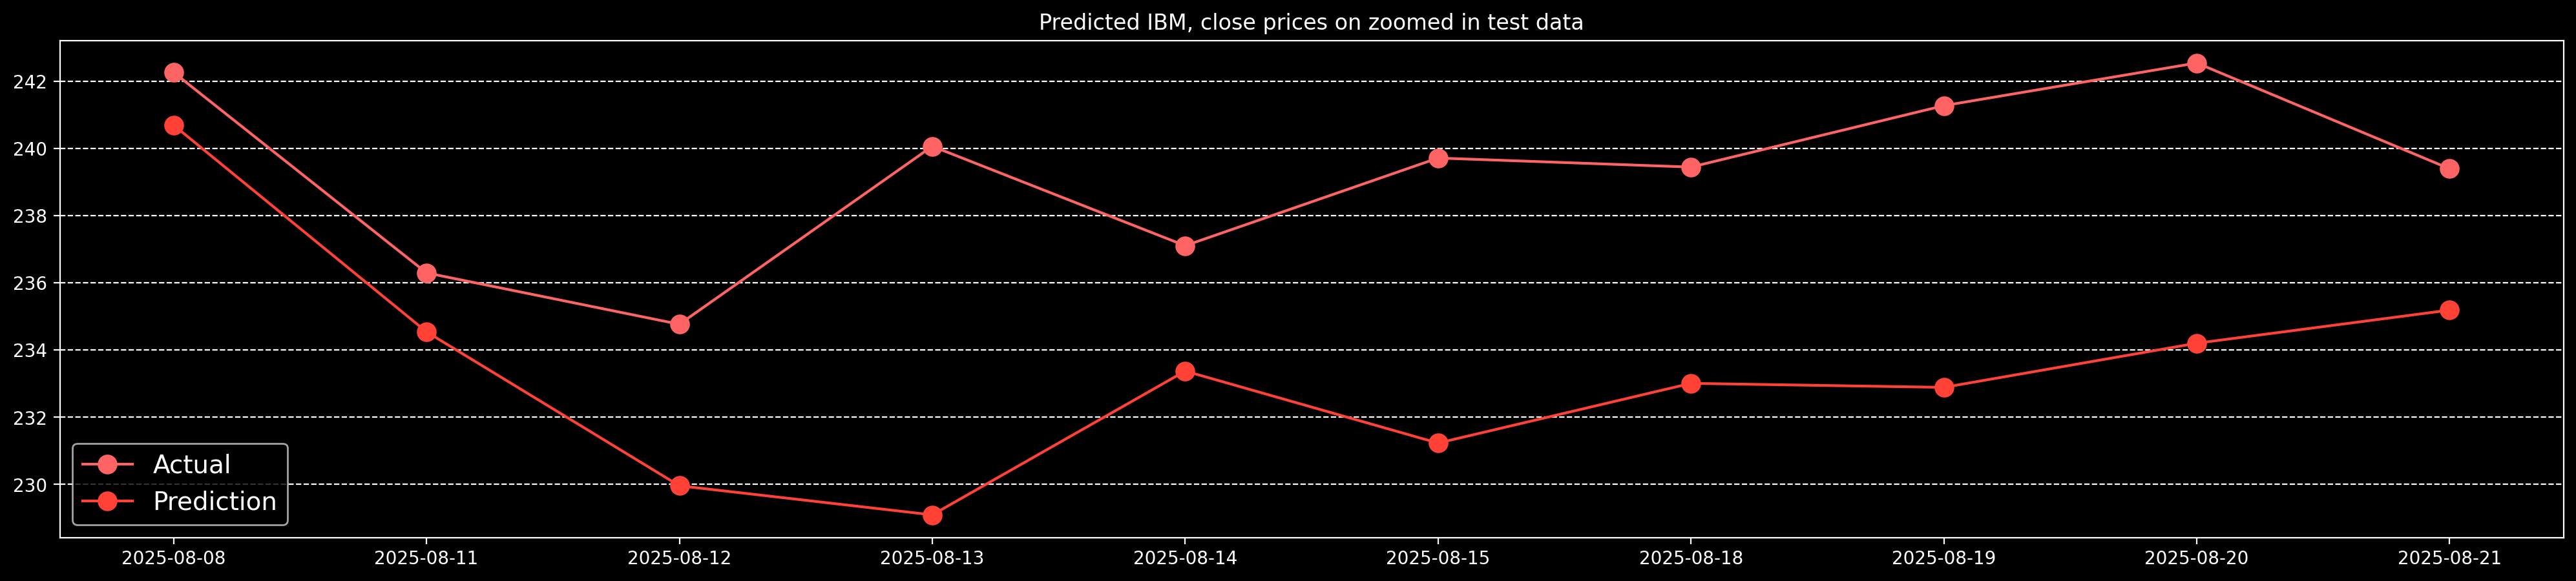

In [ ]:
y_test_zoomed = y_test_only[-10:]
y_test_preds_zoomed = y_test_preds[-10:]

data_dates_test_zoomed = data_dates[-10:]


fig = plt.figure(figsize=(25, 5), dpi=200)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates_test_zoomed, y_test_zoomed, label = "Actual", color=config["plots"]["color_test"], marker="o", markersize=10)
plt.plot(data_dates_test_zoomed, y_test_preds_zoomed, label = "Prediction", color=config["plots"]["color_pred_test"], marker="o", markersize=10)


plt.title(f"Predicted {config["alpha_vantage"]["symbol"]}, close prices on zoomed in test data")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14)